# 트랜스포머로 만드는 대화형 챗봇

- 챗봇
     - 대화형
     - 트리형
     - 추천형
     - 시나리오형
     - 결합형
- 현재 챗봇
    - Transformer 기반의 pretrained 모델
        - 병렬처리
        - LSTM에 비해 빠른 처리 속도
        - 장기 의종성에 강건
- 오늘의 목표
    - 인코더 디코더 구조를 바탕으로 한 챗봇 제작
        - 인코더
            - 문장의 이해
        - 디코더
            - 인코더의 출력 벡터를 바탕으로 문장 생성
- 과정
    - 트랜스포머
    - 어텐션
    - 스케일드 닷 프로덕트 어텐션
    - 마스킹
    - 인코더
    - 디코더
    - 병렬 데이터
    - 전처리
    - 모델 정의 및 학습
    - 테스트

In [1]:
# 모듈 불러오기
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

- 단어 임베딩 벡터로 전환
- 다른 모델과 다르게 Transformer 모델은 임베딩 값에 입력 값과 차원이 같은 Positional Encoding 값을 더해준다
- 상대적인 위치 정보를 주기 위함이다.
- 논문에서는 positional Encoding을 진행할 때 sinusoidal version을 사용한다고 한다,
    - 상대적인 위치 정보를 포함하고 있어야하기 때문에
    - 선형 변환이 가능해야 하기 때문에
    - Positional Encoding
        - 임베딩 벡터와 덧셈 연산으로 주기성과 상대적인 위치 정보를 포함한 임베딩 벡터를 입력으로 사용할 수 있게 된다.
        - 조건
            - 각 time step마다 유니크한 값이어야 한다
            - 긴 문장에도 적용가능하도록 일반화 되어야 한다
    - sin cos , 홀수 짝수를 번갈아 가면서 matrix를 구성한 이유(?)
       -  `We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of PEpos.` (논문 일부)

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

        # PE 수식 - 포지셔널 인코딩의 벡터값을 구하는 수식
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    # position - sequence의 길이
    # d_model - 인코딩 벡터의 크기
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        # position - position 마큼의 열벡터 생성
        # i - d_model 만큼의 행벡터 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        

        # 배열의 짝수 인덱스에는 sin 함수 적용 - 상대적인 위치값 부여..?
        sines = tf.math.cos(angle_rads[:, 1::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.sin(angle_rads[:, 0::2])

        # sin과 cosine이 교차되도록 재배열
        # 홀수 짝수가 번갈아 가면서 구성되도록 한다
        # 그 이유는 ..
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    
    # 결론적으로 input 임베딩 값에 PE를 더해준다.
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



In [3]:
sines = np.array([1,2,3,4,5,6])
cosines = np.array([-1,-2,-3,-4,-5,-6])

# 행방향으로 쌓는 tf.stack axis = 0인 경우
# sin cos 함수를 거친 값이 번갈아 가면서 쌓인다
pos = tf.stack([sines, cosines], axis=0)
print(pos)
print("==================")

pos = tf.transpose(pos,[1,0])
pos

tf.Tensor(
[[ 1  2  3  4  5  6]
 [-1 -2 -3 -4 -5 -6]], shape=(2, 6), dtype=int32)


<tf.Tensor: shape=(6, 2), dtype=int32, numpy=
array([[ 1, -1],
       [ 2, -2],
       [ 3, -3],
       [ 4, -4],
       [ 5, -5],
       [ 6, -6]], dtype=int32)>

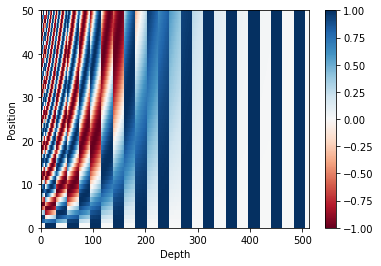

In [4]:
# 길이가 50인 문장의 각 단어의 차원이 512인 벡터의 positional encoding
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Attention
- Q : 쿼리 , 영향을 받는
- K : 키 , 영향을 주는
- V : 값 , 영향에 대한 가중치
- 이 값들은 embeding 된 Input 값에 새로운 부분 공간을 생성하는 행렬 W(q,k,v)를 각각 곱해서 트랜스포머에서 연산 된 Q,K,V를 사용해서 이후에 Attention 값을 구하는데 사용되는 것 같다
- 주요 컨셉은 단어들 간의 유사도를 구하는 메커니즘
- 모두 내적을 통해 유사도와 값을 반영해주는 작업을 한다.
- 유사도가 반영된 값들을 모두 더해준 최종 결과가 Attention Value 이다.

- 스케일드 닷 프로덕트 어텐션
    - Q*K - 문장 내에서 모든 토큰 간의 유사도
    - 스케일링을 위해 d로 나눠준다
    - 0과 1 사이의 값으로 normalize 해주기 위해 소프트맥스 함수 사용
    - 결과 값을 V와 곱해주면 Attention value Matrix

- Transformer의 3가지 어텐션
    - 인코더 셀프 어텐션 : 문장 내 단어들 간의 유사도
    - 디코더 셀프 어텐션 : 이미 생성된 단어들 간의 유사도 (마스킹)
    - 인코더 디코더 어텐션 : 인코더에서 입력된 단어들과 유사도 (Residual connection 처리)
 

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트 - 유사도 
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화 - 너무 커지는 것을 방지
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 실제 의미 있는 입력이 아닌 경우에 모델이 이를 무시하도록 하기 위해 패딩에 마스크를 적용
    #어텐션 가중치를 계산할 때 패딩 위치에 해당하는 가중치를 낮춰주면, 실제 입력에 해당하는 부분의 어텐션만을 고려
    # 작게 적용한 값은 이후에 softmax 함수를 거치면서 무시할 수 있을 정도로 작아지게 된다
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용 - 0과 1사이의 값으로 Normalize
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트 - Attention Matrix
    output = tf.matmul(attention_weights, value)
    return output


### 병렬로 어텐션 수행 - 멀티 헤드 어텐션

- multi-head Attention
    - head 변수를 통해 몇개의 어텐션 연산을 수행할지를 결정하는 파라미터이다
    - d_model은 dv x num_heads
    - d_model을 head만큼 쪼개서 dv 벡터 각각에 대해서 어텐션을 수행하고 head 각각에서 나온 결과 값들을 다시 하나로 concatenate 한다.

- 멀티 헤드 어텐션의 효과
    - 음.. 이해하기로는 한 문장에서 문장을 쪼갠 토큰 각각을 나타내는 임베딩 벡터 값들이 head 만큼 쪼개져서 head만큼의 관점으로 그 단어를 바라볼 수 있는 것이다.

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    # 병렬 처리 head 설정
    self.num_heads = num_heads
    # 임베딩 입력 차원
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    
    # 입력 임베딩 차원을 head 만큼 나누기
    self.depth = d_model // self.num_heads
    
    # Q, K, V 모두 입력 임베딩 차원꽈 동일 하고 입력 임베딩 값과 연산해서 생성하기 때문에 필요한 것 같음
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    # input 값을 batch size 만큼 , 단어 행, head 갯수 만큼, d_model // head 만큼 
    # perm은 차원 수를 나타내는 것 같음 batch, num_heads, -1 , self.depth 라는 것 같음
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 batch 크기 만큼 각각 Dense를 적용합니다 
    # 이 코드에서는 batch size가 전체 sequence인 것 같다..
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    # d_model과 차원이 같고 임벧딩 입력값과 함께 연산을 해야하기 때문에
    # head로 차원을 나눳서 reshape 해준다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수 - 내젂하고 d로 나누고 곱하고 더하는 연산
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    
    # transpose 하는데 값 위치 조정
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    # 아마도 어텐션 결과 최종 출력을 원하는 형태로 다시 맞추기 위해서 한번 더 거치는 layer 인 것 같다..
    outputs = self.dense(concat_attention)

    return outputs

### Masking
- 특정 값을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

- Transformer에서 masking
    - padding masking
        - padding token을 사용한 방법
        - 문장의 길이가 서로 다를 때 모든 문장의 길이를 동일하게 해주는 과정
        - 입력 데이터가 들어갈 때는 padding making 처리를 하는 것 같지만, 결론적으로 어텐션등과 같은 연산에서는 무시할 수  있도록 앞서 코드를 살펴본 것 처럼 무시할 수 있을 정도의 값으로 처리해둔다.
    - look ahead masking
        - 문장 행렬을 한 번에 행렬 형태로 입력으로 들어간다.
        - 이런 특징 때문에 추가적인 마스킹을 해준다
        - 목적이 이전 단어들로 이후 단어를 예측하는 것이다. 그런데 트랜스포머 모델은 무장 단위로 들어가기 때문에 모든 단어가 후보가 될 수 있다.따라서 자신보다 다음에 나올 단어는 참고하지 말라는 무엇인가 필요하다. 이것이 룩어헤드 마스킹 기법이다.
        - 디코더에서 적용되는 기법
        - 스케일드 닷 프로덕트를 하면서 Q*K 내적연산에서 마스킹된 값을 V와 내적해서 Attention matrix를 만들게 된다

### Padding mask 함수

In [7]:
# padding  masking
# 0 위치의 값을 1로 처리
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### Look ahead mask 함수

In [9]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # 대각 행렬 생성 ,-1은 주 대각선 아래쪽을 의미하고, 0은 주 대각선
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    #입력 시퀀스에서 패딩 토큰의 위치를 1로, 나머지를 0
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
tf.linalg.band_part(tf.ones((10, 10)), -1, 0)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [11]:
# 1이 masking된 부분
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 인코더
- self-attention
    - multi - head attention으로 병렬적으로 처리
- FFNN

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층 Feed forward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # 왜 dropout을...? positional 인코딩 방금했는데..
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
    
    # 입력과 패딩 마스크를 받아서 출력을 생성하는 이유는 모델이 입력 시퀀스를 처리하고, 
    # 각 층에서 어텐션을 수행하면서 패딩 마스크를 고려하여 적절한 가중치를 부여하기 위함
    # 패딩된 부분은 어텐션 연산에서 제외되어야 하기 때문에 각 층에서 패딩 마스크를 활용
    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 디코더 - 셀프 어텐션, 인코더 디코더 어텐션, 멀티헤드 어텐션 함수

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    #epsilon값은 무엇인가?
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

# num layer만큼 층 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 데이터 가져오기

In [16]:
data_path = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/'
path_to_chat = os.path.join(data_path,'ChatbotData.csv')
print(path_to_chat)

/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv


In [17]:
#path_to_zip = tf.keras.utils.get_file(
#    'cornell_movie_dialogs.zip',
#    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
#    extract=True)

#path_to_dataset = os.path.join(
#    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

#path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
#path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

In [18]:
import pandas as pd
df = pd.read_csv(path_to_chat)
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [19]:
# 질문과 대답 샘플
questions = df.Q.values.tolist()
answers = df.A.values.tolist()

In [20]:
# 라벨은 뭐죠..?
df.label.value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [21]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


### 전처리 함수

In [22]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z.?!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [23]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
#questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [24]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


###  데이터셋에 대해서 Vocabulary 생성

In [25]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [26]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [27]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [28]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [29]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


In [30]:
# 데이터 셋의 최대 길이 알아보기
for i in range(0,len(questions)-1):
    x = np.maximum(len(questions[i]),len(questions[i+1]))
    y = np.maximum(len(answers[i]),len(answers[i+1]))
print(x,y)

23 24


In [31]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [32]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [33]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [36]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5254656     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [37]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    # 0과 일치하지 않은 값
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        # tf.cast는 타입을 변경하는 함수 
        #원래 float64인데 메모리 때문에 바꾸는 것 같군요
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

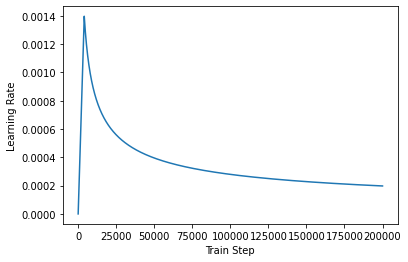

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 1000
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.3701 - accuracy: 0.0401
Epoch 2/1000
185/185 [==============================] - 20s 110ms/step - loss: 1.3687 - accuracy: 0.0401
Epoch 3/1000
185/185 [==============================] - 20s 110ms/step - loss: 1.3639 - accuracy: 0.0404
Epoch 4/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.3654 - accuracy: 0.0403
Epoch 5/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.3620 - accuracy: 0.0404
Epoch 6/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.3615 - accuracy: 0.0405
Epoch 7/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.3595 - accuracy: 0.0403
Epoch 8/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.3579 - accuracy: 0.0404
Epoch 9/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.3570 - accuracy: 0.0403
Epoch 10/1000
185/185 [==============================] 

185/185 [==============================] - 20s 110ms/step - loss: 1.2508 - accuracy: 0.0421
Epoch 79/1000
185/185 [==============================] - 20s 110ms/step - loss: 1.2480 - accuracy: 0.0420
Epoch 80/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2477 - accuracy: 0.0423
Epoch 81/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2460 - accuracy: 0.0424
Epoch 82/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2431 - accuracy: 0.0424
Epoch 83/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2438 - accuracy: 0.0425
Epoch 84/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2401 - accuracy: 0.0427
Epoch 85/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2392 - accuracy: 0.0424
Epoch 86/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.2379 - accuracy: 0.0426
Epoch 87/1000
185/185 [==============================] - 20s

185/185 [==============================] - 20s 109ms/step - loss: 1.1963 - accuracy: 0.0443
Epoch 155/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1942 - accuracy: 0.0448
Epoch 156/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1969 - accuracy: 0.0444
Epoch 157/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1976 - accuracy: 0.0444
Epoch 158/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1974 - accuracy: 0.0445
Epoch 159/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1969 - accuracy: 0.0443
Epoch 160/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1958 - accuracy: 0.0443
Epoch 161/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1977 - accuracy: 0.0442
Epoch 162/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1958 - accuracy: 0.0443
Epoch 163/1000
185/185 [============================

185/185 [==============================] - 20s 109ms/step - loss: 1.1750 - accuracy: 0.0442
Epoch 231/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1848 - accuracy: 0.0439
Epoch 232/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1843 - accuracy: 0.0440
Epoch 233/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1787 - accuracy: 0.0443
Epoch 234/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1747 - accuracy: 0.0444
Epoch 235/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1822 - accuracy: 0.0443
Epoch 236/1000
185/185 [==============================] - 20s 110ms/step - loss: 1.1944 - accuracy: 0.0438
Epoch 237/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1982 - accuracy: 0.0436
Epoch 238/1000
185/185 [==============================] - 21s 112ms/step - loss: 1.2091 - accuracy: 0.0434
Epoch 239/1000
185/185 [============================

185/185 [==============================] - 20s 108ms/step - loss: 1.1524 - accuracy: 0.0454
Epoch 312/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1535 - accuracy: 0.0448
Epoch 313/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1564 - accuracy: 0.0450
Epoch 314/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1604 - accuracy: 0.0444
Epoch 315/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1590 - accuracy: 0.0446
Epoch 316/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1605 - accuracy: 0.0446
Epoch 317/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1636 - accuracy: 0.0445
Epoch 318/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1647 - accuracy: 0.0446
Epoch 319/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1686 - accuracy: 0.0445
Epoch 320/1000
185/185 [============================

185/185 [==============================] - 20s 108ms/step - loss: 1.1533 - accuracy: 0.0450
Epoch 390/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1525 - accuracy: 0.0446
Epoch 391/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1497 - accuracy: 0.0447
Epoch 392/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1503 - accuracy: 0.0447
Epoch 393/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1495 - accuracy: 0.0449
Epoch 394/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1476 - accuracy: 0.0448
Epoch 395/1000
185/185 [==============================] - 21s 112ms/step - loss: 1.1460 - accuracy: 0.0449
Epoch 396/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1483 - accuracy: 0.0450
Epoch 397/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1526 - accuracy: 0.0447
Epoch 398/1000
185/185 [============================

185/185 [==============================] - 20s 108ms/step - loss: 1.1456 - accuracy: 0.0452
Epoch 466/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1517 - accuracy: 0.0451
Epoch 467/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1477 - accuracy: 0.0450
Epoch 468/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1495 - accuracy: 0.0450
Epoch 469/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1481 - accuracy: 0.0450
Epoch 470/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1438 - accuracy: 0.0453
Epoch 471/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1461 - accuracy: 0.0450
Epoch 472/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1465 - accuracy: 0.0451
Epoch 473/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1489 - accuracy: 0.0449
Epoch 474/1000
185/185 [============================

185/185 [==============================] - 20s 107ms/step - loss: 1.1192 - accuracy: 0.0454
Epoch 542/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1167 - accuracy: 0.0453
Epoch 543/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1182 - accuracy: 0.0456
Epoch 544/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1202 - accuracy: 0.0453
Epoch 545/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1214 - accuracy: 0.0456
Epoch 546/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1187 - accuracy: 0.0453
Epoch 547/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1248 - accuracy: 0.0453
Epoch 548/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1225 - accuracy: 0.0450
Epoch 549/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1194 - accuracy: 0.0457
Epoch 550/1000
185/185 [============================

185/185 [==============================] - 20s 108ms/step - loss: 1.1237 - accuracy: 0.0451
Epoch 618/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1151 - accuracy: 0.0455
Epoch 619/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1113 - accuracy: 0.0459
Epoch 620/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1117 - accuracy: 0.0455
Epoch 621/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1129 - accuracy: 0.0454
Epoch 622/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1144 - accuracy: 0.0455
Epoch 623/1000
185/185 [==============================] - 20s 109ms/step - loss: 1.1126 - accuracy: 0.0453
Epoch 624/1000
185/185 [==============================] - 20s 110ms/step - loss: 1.1113 - accuracy: 0.0455
Epoch 625/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1103 - accuracy: 0.0452
Epoch 626/1000
185/185 [============================

185/185 [==============================] - 20s 107ms/step - loss: 1.1137 - accuracy: 0.0455
Epoch 694/1000
185/185 [==============================] - 20s 108ms/step - loss: 1.1119 - accuracy: 0.0455
Epoch 695/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1123 - accuracy: 0.0454
Epoch 696/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1116 - accuracy: 0.0455
Epoch 697/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1186 - accuracy: 0.0455
Epoch 698/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1179 - accuracy: 0.0453
Epoch 699/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1144 - accuracy: 0.0454
Epoch 700/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1129 - accuracy: 0.0454
Epoch 701/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1102 - accuracy: 0.0456
Epoch 702/1000
185/185 [============================

185/185 [==============================] - 20s 107ms/step - loss: 1.1483 - accuracy: 0.0453
Epoch 770/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1487 - accuracy: 0.0453
Epoch 771/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1529 - accuracy: 0.0455
Epoch 772/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1367 - accuracy: 0.0457
Epoch 773/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1264 - accuracy: 0.0455
Epoch 774/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1242 - accuracy: 0.0454
Epoch 775/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1227 - accuracy: 0.0451
Epoch 776/1000
185/185 [==============================] - 20s 106ms/step - loss: 1.1188 - accuracy: 0.0453
Epoch 777/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1067 - accuracy: 0.0459
Epoch 778/1000
185/185 [============================

185/185 [==============================] - 20s 107ms/step - loss: 1.0947 - accuracy: 0.0455
Epoch 846/1000
185/185 [==============================] - 20s 106ms/step - loss: 1.1143 - accuracy: 0.0449
Epoch 847/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.0926 - accuracy: 0.0455
Epoch 848/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1101 - accuracy: 0.0455
Epoch 849/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.1191 - accuracy: 0.0456
Epoch 850/1000
185/185 [==============================] - 20s 106ms/step - loss: 1.1242 - accuracy: 0.0457
Epoch 851/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.0972 - accuracy: 0.0457
Epoch 852/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.0933 - accuracy: 0.0457
Epoch 853/1000
185/185 [==============================] - 20s 107ms/step - loss: 1.0933 - accuracy: 0.0457
Epoch 854/1000
185/185 [============================

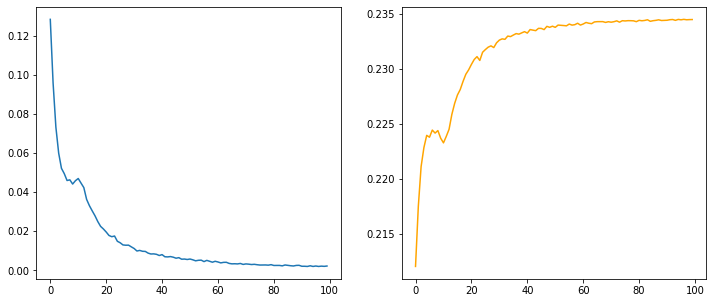

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='accuracy',color='orange')

In [34]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [35]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

### epoch 10 번

In [111]:
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 많이 만나보세요.


'많이 만나보세요.'

In [112]:
sentence_generation("너는 누구니?")

입력 : 너는 누구니?
출력 : 직접 물어보세요.


'직접 물어보세요.'

### epoch 100번

In [127]:
sentence_generation('안녕하세요')
print("---------------------------------------")
sentence_generation("너는 누구니?")

입력 : 안녕하세요
출력 : 휴가가 간절하겠네요.
---------------------------------------
입력 : 너는 누구니?
출력 : 신뢰입니다.


'신뢰입니다.'

In [39]:
BATCH_SIZE = 64 # 64->128
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [49]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수 2  -> 3
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [50]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [51]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 14s 47ms/step - loss: 1.9459 - accuracy: 0.0280
Epoch 2/10
185/185 [==============================] - 9s 47ms/step - loss: 1.5850 - accuracy: 0.0643
Epoch 3/10
185/185 [==============================] - 9s 47ms/step - loss: 1.3559 - accuracy: 0.0677
Epoch 4/10
185/185 [==============================] - 8s 46ms/step - loss: 1.2490 - accuracy: 0.0730
Epoch 5/10
185/185 [==============================] - 8s 46ms/step - loss: 1.1677 - accuracy: 0.0781
Epoch 6/10
185/185 [==============================] - 8s 46ms/step - loss: 1.0819 - accuracy: 0.0842
Epoch 7/10
185/185 [==============================] - 9s 46ms/step - loss: 0.9864 - accuracy: 0.0927
Epoch 8/10
185/185 [==============================] - 8s 46ms/step - loss: 0.8810 - accuracy: 0.1041
Epoch 9/10
185/185 [==============================] - 9s 46ms/step - loss: 0.7665 - accuracy: 0.1164
Epoch 10/10
185/185 [==============================] - 9s 46ms/step - loss: 0.6483 - accur

### 동일한 조건에서 하이퍼파라미터 각각 실험
- Batch size 64 -> 128
    - 결과 : 이전과 다를 것이 없다
    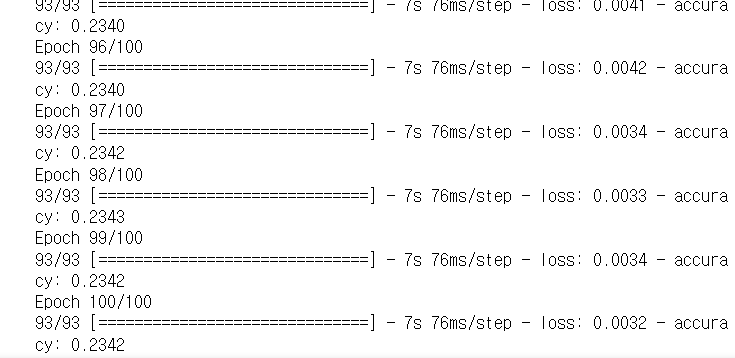
- 인코더와 디코더 층의 갯수 2 -> 4
    - 결과 : 시간은 5초정도 늘어났지만 LOSS값이 더 적은 상태로 시작하고 빠르게 떨어졌다. 근데 결과적으로는 더 성능은 떨어졌다..
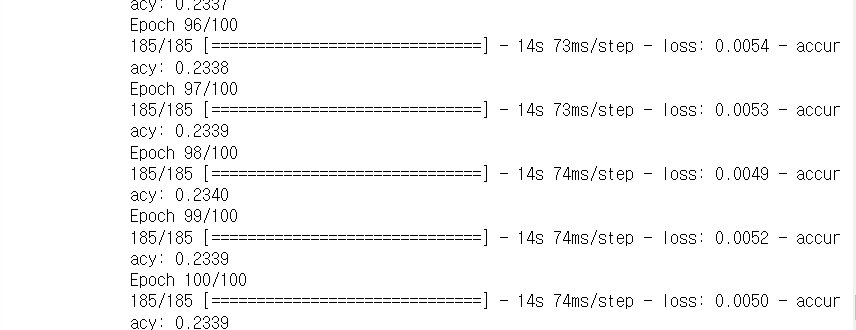
    
- num_head 갯수 8 -> 10
    - 결과


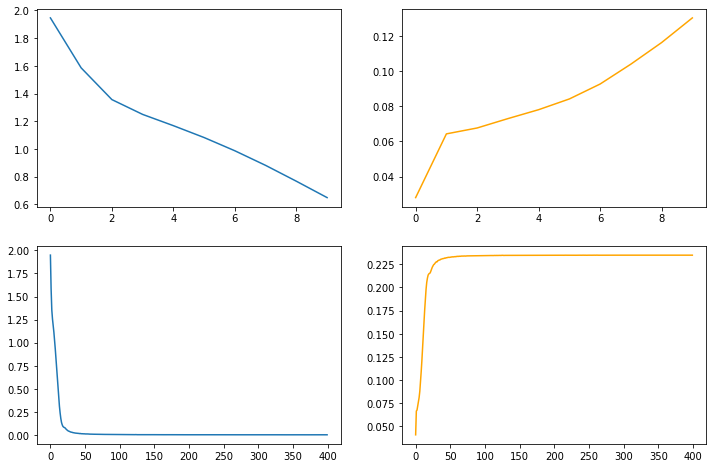

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],label='accuracy',color='orange')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'], label='loss')
plt.subplot(2,2,4)
plt.plot(history1.history['accuracy'],label='accuracy',color='orange')

In [54]:
sentence_generation('안녕하세요')
print("---------------------------------------")
sentence_generation("너는 누구니?")

입력 : 안녕하세요
출력 : 제가 있잖아요.
---------------------------------------
입력 : 너는 누구니?
출력 : 저는 마음을 이어주는 위로봇입니다.


'저는 마음을 이어주는 위로봇입니다.'

In [55]:
sentence_generation("오늘은 좀 슬픈네")

입력 : 오늘은 좀 슬픈네
출력 : 제가 있잖아요.


'제가 있잖아요.'

## 회고
- 인공지능에서 큰 영향을  준 트랜스포머 모델을 직접 알아보고 사용해보는 것 자체로 의미가 있었다.
- 문장 자체를 토큰화해서 각 행으로 구성되어 입력으로 들어가고, head만큼에 관점으로 바라볼 수 있도록 구성했다는 점과 출력 이전에 단어만 볼 수 있도록 디코더에만 masking 처리하는 부분도 흥미로웠다. 또 attention matrix를 통해서 위치에 대한 정보도 가져갈 수 있도록 하는 부분도 좋은 인사이트가 되었다.
- 현재는 훈련 시간 상 layer를 적게 가져가서 그런가 100번이나 500번이나 모두 성능의 큰 차이가 없고 특정 시점에서 수렴해버렸다. 그 이유에 대해서도 다양한 실험을 해보면서 알아보면 좋을 것 같다
- head의 개념을 관점으로 해석을 한다면 관점이 다양했을 때 사람처럼 해석의 범위가 더 넓어질 수 있을까? 와 은닉층의 크기에 따라서 얼마나 성능이 달라질지, ResNet 처럼 layer를 더 많이 쌓으면 좋을지에 대한 것도 궁금해서 추후에 더 많은 실험을 해보고 싶다.